# Dreem Challenge Report - CentraleSupélec

# Abderrahim Mehdaoui & Adnan Zeddoun

## Context

Sleep plays a vital role in an individual’s health and well-being. Sleep progresses in cycles that involve multiple sleep stages : wake, light sleep, deep sleep, rem sleep. Different sleep stages are associated to different physiological functions. Monitoring sleep stage is beneficial for diagnosing sleep disorders. The gold standard to monitor sleep stages relies on a polysomnography study conducted in a hospital or a sleep lab. Different physiological signals are recorded such as electroencephalogram, electrocardiogram etc.

Sleep stage scoring is then performed visually by an expert on epochs of 30 seconds of signals recording. The resulting graph is called a hypnogram. He provides a compact description the night. 

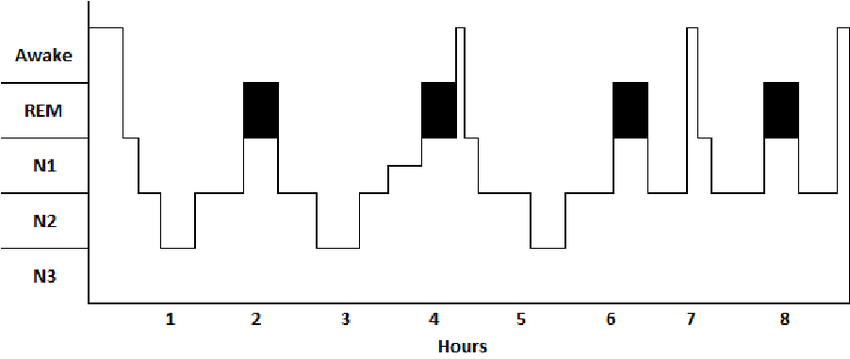

In [1]:
import os
from IPython.display import Image
Image(os.path.join('Hypnogram.png'))

## The Dreem headband

 Dreem headband allows doing polysomnography at home signal thanks to three kinds of sensors: electroencephalogram (EEG), pulse oximeter and accelerometer signals.

Since the Dreem headband records a lot of nights every day, we spent time developing the most accurate automatic sleep staging algorithms. Data was labeled directly on our data by trained sleep expert.

In this challenge we provide you with such labelled data. The idea is to develop an algorithm of sleep staging able to differentiate between Wake, N1, N2, N3 and REM on windows of 30 seconds of raw data. The raw data includes 7 eegs channels in frontal and occipital position, 1 pulse oximeter infrared channel, and 3 accelerometers channels (x, y and z).

## Packages loading

In [1]:
#Import the necessary moduls for features extraction
import pandas as pd
import scipy.signal as scs
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as stat
from scipy.special import entr
import pywt
import os


#Import the necessary moduls to train the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

## Data loading

In [2]:
#Loading the files
X_train = h5py.File(os.path.join('data', 'X_train.h5'), 'r')
X_test = h5py.File(os.path.join('data', 'X_test.h5'), 'r')
keys = list(X_train.keys())
for k in keys:
    print(k, X_train[k].shape)

eeg_1 (24688, 1500)
eeg_2 (24688, 1500)
eeg_3 (24688, 1500)
eeg_4 (24688, 1500)
eeg_5 (24688, 1500)
eeg_6 (24688, 1500)
eeg_7 (24688, 1500)
index (24688,)
index_absolute (24688,)
index_window (24688,)
pulse (24688, 300)
x (24688, 300)
y (24688, 300)
z (24688, 300)


In [4]:
y_train = pd.read_csv(os.path.join('data', 'y_train.csv'))
print('y columns', y_train.columns)
print(y_train.head())

y columns Index(['index', 'sleep_stage'], dtype='object')
   index  sleep_stage
0      0            0
1      1            0
2      2            0
3      3            0
4      4            0


## Features engineering

### Temporal features
When we use temporal series, we usually take classical statistical features, we have done so by picking: <br>

1) Statistical features:
  - Mean 
  - Standard deviation
  - Skewness
  - Kurtosis
  - First quartile
  - Third quartile

2) Signal processing features: 
   - The entropy of the wavelet transform
   - Zero crossing
   - The distance between the maximum and the minimum in each sub-window(only for eeg)
   - The maximum of the PSD
   - The Esis for eeg (cf reference)


### Frequency features

We pass on frequency domain for the eeg signals to extract the different sub-band (alpha, beta, delta, theta) and compute some other statistical moments.

We have also filtered the signal with a butter filter (order 4, bandpass) to compute some statistical features as well as it was mentioned to filter the signal in the paper.

## Features extraction

In [5]:
#Compute the sum of distance between max and min in each subwindow of size 100
def MMD(x):
    lmb = 100
    mmd = np.zeros((x.shape[0]))
    for i in range(-1,x.shape[1]-100,100):
        max_v = np.max(x[:,i+1:i+100], axis=1)
        min_v = np.min(x[:,i+1:i+100], axis=1)
        argmax = np.argmax(x[:,i+1:i+100], axis=1)/50
        argmin = np.argmin(x[:,i+1:i+100], axis=1)/50
        dist = np.sqrt(np.abs(max_v-min_v)**2+np.abs(argmax-argmin)**2)
        mmd += dist
    return mmd

In [6]:
#Compute the Esis feature which represents the enregy of the signal
def Esis(x, freq_min, freq_max):
    lmb = 100
    f = (freq_min + freq_max)/2
    return lmb*f*np.sum(np.power(x,2), axis=1)/x.shape[1]

In [7]:
def extract_features_eeg(x):
    
    nb_rows = x.shape[0]
    features = np.empty((nb_rows, 17))
    moment = stat.describe(x, axis = 1)
    
    #Taking the wavelet transform on the time domain
    Wave_cA = np.absolute(pywt.dwt(x,'db4', axis=1)[0])
    Wave_cD = np.absolute(pywt.dwt(x,'db4', axis=1)[1])
    
    pA = Wave_cA/Wave_cA.sum(axis=1, keepdims=True)
    pD = Wave_cD/Wave_cD.sum(axis=1, keepdims=True)
    
    #Compute the probability for the entropy
    S_abs = np.absolute(x)
    p = S_abs/S_abs.sum(axis=1, keepdims=True)

    # Defining eeg bands
    #features[:,16] = entr(pD).sum(axis=1) #entropy on Wavelet transformation
    #features[:,15] = entr(pA).sum(axis=1) #entropy on Wavelet transformation
    features[:,14] = entr(p).sum(axis=1) #entropy of the signal
    features[:,12] = Esis(x, 13, 22) #Esis on the beta band
    features[:,11] = Esis(x, 8, 13) #Esis on the alpha band
    features[:,10] = Esis(x, 4, 8) #Esis on the theta band
    features[:,9] = Esis(x, 0, 4) #Esis on the delta band
    features[:,8] = np.quantile(x, 0.75, axis = 1)    
    features[:,7] = np.quantile(x, 0.25, axis = 1)
    features[:,6] = np.max(sig.welch(x, fs = 50, axis = 1)[1][:,0:15], axis = 1) #max of power spectra density
    features[:,5] = moment[5] #kurtozis
    features[:,4] = moment[4] #skweness
    features[:,3] = moment[3] #Standard deviation
    features[:,2] = moment[2] #mean
    features[:,1] = MMD(x) 
    features[:,0] = np.sum(((x[:,:-1]*x[:,1:])<0), axis=1) #zero crossing
    return features

In [8]:
def feature_extraction_acc(x):
    
    nb_rows = x.shape[0]
    features = np.empty((nb_rows, 9))
    moment = stat.describe(x, axis = 1)


    #print("---------- Extracting accelerometer temporal features : ----------")
    #print("Median, standard deviation, skew, kurtosis, zero crossing, max, /entropy/, /crest factor/")
    features[:,8] = np.quantile(x, 0.75, axis = 1)    
    features[:,7] = np.quantile(x, 0.25, axis = 1)
    features[:,6] = np.sum(((x[:,:-1]*x[:,1:])<0), axis=1) #zero crossing
    features[:,5] = moment[5] #kurtosis
    features[:,4] = moment[4] #skweness
    features[:,3] = moment[3] #standard deviation
    features[:,2] = moment[2] #mean
    features[:,1] = moment[1][1] #max
    features[:,0] = moment[1][0] #min
    return features

In [9]:
def feature_extraction_pulse(x):
    nb_rows = x.shape[0]

    features = np.empty((nb_rows, 9))
    moment = stat.describe(x, axis = 1)


    #print("---------- Extracting pulse oximeter temporal features : ----------")
    #print("Median, standard deviation, skew, kurtosis, zero crossing, max, /entropy/, /crest factor/")
    features[:,8] = np.quantile(x, 0.75, axis = 1)    
    features[:,7] = np.quantile(x, 0.25, axis = 1)
    features[:,6] = np.sum(((x[:,:-1]*x[:,1:])<0), axis=1) #zero crossing
    features[:,5] = moment[5] #kurtosis
    features[:,4] = moment[4] #skweness
    features[:,3] = moment[3] #standard deviation
    features[:,2] = moment[2] #mean
    features[:,1] = moment[1][1] #max
    features[:,0] = moment[1][0] #min
    return features

In [10]:
#Extracting the features from the training set

print("---------- Extracting eeg features : ----------")
#print("max_min_dist, mean, std deviation, zero crossing, skewness, kurtozis, entropy, Esis")

X_train_eeg_feat = np.empty((X_train['eeg_1'].shape[0], 0))
X_test_eeg_feat = np.empty((X_test['eeg_1'].shape[0], 0))

for k in keys[0:7]:
    print("Processing on {} ......................".format(k))
    x_train = X_train[k]
    x_test = X_test[k]
    eeg_feat_train = extract_features_eeg(x_train)
    eeg_feat_test = extract_features_eeg(x_test)
    X_train_eeg_feat = np.concatenate((X_train_eeg_feat, eeg_feat_train), axis=1)
    X_test_eeg_feat = np.concatenate((X_test_eeg_feat, eeg_feat_test), axis=1)

---------- Extracting eeg features : ----------
Processing on eeg_1 ......................
Processing on eeg_2 ......................
Processing on eeg_3 ......................
Processing on eeg_4 ......................
Processing on eeg_5 ......................
Processing on eeg_6 ......................
Processing on eeg_7 ......................


In [11]:
print("---------- Extracting accelerometer temporal features : ----------")
#print("Median, standard deviation, skew, kurtosis, zero crossing, max, /entropy/, /crest factor/")

X_train_acc_feat = np.empty((X_train['x'].shape[0], 0))
X_test_acc_feat = np.empty((X_test['x'].shape[0], 0))

for k in keys[11:]:
    print("Processing on {} ......................".format(k))
    x_train = X_train[k]
    x_test = X_test[k]
    acc_feat_train = feature_extraction_acc(x_train)
    acc_feat_test = feature_extraction_acc(x_test)
    X_train_acc_feat = np.concatenate((X_train_acc_feat, acc_feat_train), axis=1)
    X_test_acc_feat = np.concatenate((X_test_acc_feat, acc_feat_test), axis=1)

---------- Extracting accelerometer temporal features : ----------
Processing on x ......................
Processing on y ......................
Processing on z ......................


In [12]:
print("---------- Extracting pulse oximeter temporal features : ----------")
#print("Median, standard deviation, skew, kurtosis, zero crossing, max, /entropy/, /crest factor/")

X_train_pulse_feat = feature_extraction_acc(X_train['pulse'])
X_test_pulse_feat = feature_extraction_acc(X_test['pulse'])

---------- Extracting pulse oximeter temporal features : ----------


## Extracting band from the signal

### FFT Transform and Wavelet Transform

In [13]:
# Defining eeg bands 
eeg_bands = {'delta':[0,4],
               'theta':[4,8],
               'alpha':[8,13],
               'beta' : [13,22]}

In [14]:
def extract_band_eeg(x_freq):
    nb_rows = x_freq.shape[0]

    band_features = np.empty((nb_rows, 75))
    
    for band in eeg_bands:
        #   Bands:
        #delta= 0; theta=1; alpha=2; beta=3
        
        #Taking the frequencies that are in the band we currently consider
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq < eeg_bands[band][1]))[0]

        #Passing on time domain to compute the wavelet transform on each bands
        x_temporel = np.array(np.absolute(np.fft.irfft(x_freq[:,freq_ix], axis=1)))
        cA = pywt.wavedec(x_temporel,'db4', axis=1, level=2)[0]
        cD = pywt.wavedec(x_temporel,'db4', axis=1, level=2)[1]
        cC = pywt.wavedec(x_temporel,'db4', axis=1, level=2)[2]
        
        Wave_cA = np.absolute(pywt.wavedec(x_temporel,'db4', axis=1, level=2)[0])
        Wave_cD = np.absolute(pywt.wavedec(x_temporel,'db4', axis=1, level=2)[1])
        Wave_cC = np.absolute(pywt.wavedec(x_temporel,'db4', axis=1, level=2)[2])
        #Wave_cB = np.absolute(pywt.wavedec(x_temporel,'db4', axis=1, level=3)[3])
        pA = Wave_cA/Wave_cA.sum(axis=1, keepdims=True)
        pD = Wave_cD/Wave_cD.sum(axis=1, keepdims=True)
        pC = Wave_cC/Wave_cC.sum(axis=1, keepdims=True)
        #pB = Wave_cB/Wave_cB.sum(axis=1, keepdims=True)
        
        #Entropy on one band
        pF_ent = x_freq[:,freq_ix]/x_freq[:,freq_ix].sum(axis=1, keepdims=True)

        
        if band == 'delta':
            band_features[:,0] = 20 * np.log10(np.mean(x_freq[:,freq_ix], axis = 1))
            band_features[:,1] = 20 * np.log10(np.std(x_freq[:,freq_ix], axis = 1))
            band_features[:,2] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.75, axis = 1))
            band_features[:,3] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.25, axis = 1))
            band_features[:,4] = entr(pD).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,5] = entr(pA).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,6] = entr(pF_ent).sum(axis=1)
            band_features[:,7] = np.mean(cA, axis = 1)
            band_features[:,8] = np.std(cA, axis = 1)
            band_features[:,9] = entr(pC).sum(axis=1) #entropy on Wavelet transformation
            #band_features[:,10] = entr(pB).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,11] = np.quantile(cA, 0.5, axis = 1) #median on Wavelet transformation
            band_features[:,12] = np.mean(np.sqrt(np.power(cA,2)), axis = 1)
            band_features[:,13] = np.quantile(cA, 0.25, axis = 1)
            band_features[:,14] = np.quantile(cA, 0.75, axis = 1)
            band_features[:,15] = MMD(x_freq[:,freq_ix])
            band_features[:,16] = Esis(x_freq[:,freq_ix], 0, 4)
            band_features[:,17] = np.mean(cC, axis = 1)
            band_features[:,18] = np.std(cC, axis = 1)



        elif band == 'theta':
            band_features[:,19] = 20 * np.log10(np.mean(x_freq[:,freq_ix], axis = 1))
            band_features[:,20] = 20 * np.log10(np.std(x_freq[:,freq_ix], axis = 1))
            band_features[:,21] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.75, axis = 1))
            band_features[:,22] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.25, axis = 1))
            band_features[:,23] = entr(pD).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,24] = entr(pA).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,25] = entr(pF_ent).sum(axis=1)
            band_features[:,26] = np.mean(cA, axis = 1)
            band_features[:,27] = np.std(cA, axis = 1)
            band_features[:,28] = entr(pC).sum(axis=1) #entropy on Wavelet transformation
            #band_features[:,29] = entr(pB).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,30] = np.quantile(cA, 0.5, axis = 1) #median on Wavelet transformation
            band_features[:,31] = np.mean(np.sqrt(np.power(cA,2)), axis = 1)
            band_features[:,32] = np.quantile(cA, 0.25, axis = 1)
            band_features[:,33] = np.quantile(cA, 0.75, axis = 1)
            band_features[:,34] = MMD(x_freq[:,freq_ix])
            band_features[:,35] = Esis(x_freq[:,freq_ix], 4, 8)
            band_features[:,36] = np.mean(cC, axis = 1)
            band_features[:,37] = np.std(cC, axis = 1)


            
        elif band == 'alpha':
            band_features[:,38] = 20 * np.log10(np.mean(x_freq[:,freq_ix], axis = 1))
            band_features[:,39] = 20 * np.log10(np.std(x_freq[:,freq_ix], axis = 1))
            band_features[:,40] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.75, axis = 1))
            band_features[:,41] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.25, axis = 1))
            band_features[:,42] = entr(pD).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,43] = entr(pA).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,44] = entr(pF_ent).sum(axis=1)
            band_features[:,45] = np.mean(cA, axis = 1)
            band_features[:,46] = np.std(cA, axis = 1)
            band_features[:,47] = entr(pC).sum(axis=1) #entropy on Wavelet transformation
            #band_features[:,48] = entr(pB).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,49] = np.quantile(cA, 0.5, axis = 1) #median on Wavelet transformation
            band_features[:,50] = np.mean(np.sqrt(np.power(cA,2)), axis = 1)
            band_features[:,51] = np.quantile(cA, 0.25, axis = 1)
            band_features[:,52] = np.quantile(cA, 0.75, axis = 1)
            band_features[:,53] = MMD(x_freq[:,freq_ix])
            band_features[:,54] = Esis(x_freq[:,freq_ix], 8, 13)
            band_features[:,55] = np.mean(cC, axis = 1)
            band_features[:,56] = np.std(cC, axis = 1)


            
        elif band == 'beta':
            band_features[:,56] = 20 * np.log10(np.mean(x_freq[:,freq_ix], axis = 1))
            band_features[:,57] = 20 * np.log10(np.mean(x_freq[:,freq_ix], axis = 1))
            band_features[:,58] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.75, axis = 1))
            band_features[:,59] = 20 * np.log10(np.quantile(x_freq[:,freq_ix], 0.25, axis = 1))
            band_features[:,60] = entr(pD).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,61] = entr(pA).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,62] = entr(pF_ent).sum(axis=1)
            band_features[:,63] = np.mean(cA, axis = 1)
            band_features[:,64] = np.std(cA, axis = 1)
            band_features[:,65] = entr(pC).sum(axis=1) #entropy on Wavelet transformation
            #band_features[:,66] = entr(pB).sum(axis=1) #entropy on Wavelet transformation
            band_features[:,67] = np.quantile(cA, 0.5, axis = 1) #median on Wavelet transformation
            band_features[:,68] = np.mean(np.sqrt(np.power(cA,2)), axis = 1)
            band_features[:,69] = np.quantile(cA, 0.25, axis = 1)
            band_features[:,70] = np.quantile(cA, 0.75, axis = 1)
            band_features[:,71] = MMD(x_freq[:,freq_ix])
            band_features[:,72] = Esis(x_freq[:,freq_ix], 13, 22)
            band_features[:,73] = np.mean(cC, axis = 1)
            band_features[:,74] = np.std(cC, axis = 1)
            
    return band_features

In [15]:
X_train_bands_feat = np.empty((X_train['eeg_1'].shape[0], 0))
X_test_bands_feat = np.empty((X_test['eeg_1'].shape[0], 0))
#Extracting eeg bands
for k in keys[0:7]:
    print("Processing on {} ......................".format(k))
    x_train = np.array(X_train[k])
    x_test = np.array(X_test[k])
    #x_train = sig.detrend(x_train)
    #x_test = sig.detrend(x_test)

    print("Applying fft ....")
    fft_vals_train = np.array(np.absolute(np.fft.rfft(x_train, axis=1)))
    fft_vals_test = np.array(np.absolute(np.fft.rfft(x_test, axis=1)))

    fft_freq = np.fft.rfftfreq(x_train.shape[1], 1.0 / 50)

    fft_vals_train = extract_band_eeg(fft_vals_train)
    fft_vals_test = extract_band_eeg(fft_vals_test)
    X_train_bands_feat = np.concatenate((X_train_bands_feat, fft_vals_train), axis=1)
    X_test_bands_feat = np.concatenate((X_test_bands_feat, fft_vals_test), axis=1)

Processing on eeg_1 ......................
Applying fft ....
Processing on eeg_2 ......................
Applying fft ....
Processing on eeg_3 ......................
Applying fft ....
Processing on eeg_4 ......................
Applying fft ....
Processing on eeg_5 ......................
Applying fft ....
Processing on eeg_6 ......................
Applying fft ....
Processing on eeg_7 ......................
Applying fft ....


### Butter Filter on raw data

In [16]:
def extract_butter(x):
    nb_rows = x.shape[0]

    band_features = np.empty((nb_rows, 15))
    for band in eeg_bands:
        
        if band == 'delta':
            W = np.array([0.1,4])/25
            b, a = sig.butter(4, W, btype='bandpass')
            x_f = sig.lfilter(b, a, x, axis=1)
            p = np.absolute(x_f)/np.absolute(x_f).sum(axis=1, keepdims=True)
            
            band_features[:,0] = MMD(x_f)
            band_features[:,1] = Esis(x_f, 0, 4)
            band_features[:,2] = entr(p).sum(axis=1)
            
        elif band == 'theta':
            W = np.array([4,8])/25
            b, a = sig.butter(4, W, btype='bandpass')
            x_f = sig.lfilter(b, a, x, axis=1)
            p = np.absolute(x_f)/np.absolute(x_f).sum(axis=1, keepdims=True)
            
            band_features[:,3] = MMD(x_f)
            band_features[:,4] = Esis(x_f, 4, 8)
            band_features[:,5] = entr(p).sum(axis=1)
            
        elif band == 'alpha':
            W = np.array([8,13])/25
            b, a = sig.butter(4, W, btype='bandpass')
            x_f = sig.lfilter(b, a, x, axis=1)
            p = np.absolute(x_f)/np.absolute(x_f).sum(axis=1, keepdims=True)
            
            band_features[:,6] = MMD(x_f)
            band_features[:,7] = Esis(x_f, 8, 13)
            band_features[:,8] = entr(p).sum(axis=1)
            
 
        elif band == 'beta':
            W = np.array([13,22])/25
            b, a = sig.butter(4, W, btype='bandpass')
            x_f = sig.lfilter(b, a, x, axis=1)
            p = np.absolute(x_f)/np.absolute(x_f).sum(axis=1, keepdims=True)
            
            band_features[:,12] = MMD(x_f)
            band_features[:,13] = Esis(x_f, 13, 22)
            band_features[:,14] = entr(p).sum(axis=1)
            
    return band_features

In [17]:
X_train_filt = np.empty((X_train['eeg_1'].shape[0], 0))
X_test_filt = np.empty((X_test['eeg_1'].shape[0], 0))
#Extracting eeg bands
for k in keys[0:7]:
    print("Processing on {} ......................".format(k))
    x_train = np.array(X_train[k])
    x_test = np.array(X_test[k])
    #x_train = sig.detrend(x_train)
    #x_test = sig.detrend(x_test)

    filt_train = extract_butter(x_train)
    filt_test = extract_butter(x_test)
    X_train_filt = np.concatenate((X_train_filt, filt_train), axis=1)
    X_test_filt = np.concatenate((X_test_filt, filt_test), axis=1)

Processing on eeg_1 ......................
Processing on eeg_2 ......................
Processing on eeg_3 ......................
Processing on eeg_4 ......................
Processing on eeg_5 ......................
Processing on eeg_6 ......................
Processing on eeg_7 ......................


## Concatenation of the features

In [18]:
#scaling the temporal features
scaler = StandardScaler()

X_features_stats = np.concatenate((X_train_eeg_feat, X_train_acc_feat, X_train_pulse_feat), axis = 1)
X_features_stats_scaled = scaler.fit_transform(X_features_stats)

X_test_features_stats = np.concatenate((X_test_eeg_feat, X_test_acc_feat, X_test_pulse_feat), axis = 1)
X_test_features_stats_scaled = scaler.transform(X_test_features_stats)

#concatenate the temporal and frequency features
X_features = np.concatenate((X_train_filt, X_features_stats_scaled, X_train_bands_feat), axis = 1)
X_test_features = np.concatenate((X_test_filt, X_test_features_stats_scaled,X_test_bands_feat), axis = 1)

label = y_train['sleep_stage'] #label for the trraining set

## Modelisation

We have tried several statistical learning algorithms such as SVM, Random Forest, Logistic regression and Gradient boosting. 

Regarding the results, we have decided to focus on the last one.

### Boosting method
Boosting approach are based on the aggregation of weak learners, so there are two steps in boosting approach : 
<ul>
    <li>Building several simple models </li>
    <li>Aggregate theses models by giving them a weight $f^{*}(x)=\sum_{i=1}^{N}\alpha_{i}f_{i}(x)$ </li>
</ul>
The idea is to find a way to build these simple models $f_{i}$ to have a good $f^{*}$. <br>
Thats what we are going to introduice with the gradient boosting method.

### Defining the hyperparameters
A model can be defined with parameters that we have to define first, these are the hyperparameters. During the training step, we have tried a grid search to define the best ones, we have then adjusted them by hand to gain some places in the ranking list. 

During the whole training step, we have focused our mind on : <br>
<ul>
    <li> n_estimators, the more you have, the best your model will perform but it's computationnaly expansive and your improvment is worse than linear.</li>
    <li> learning_rate, to regularize the model, the smaller the LR is, the simpler your model will be and will prevent from overfitting.</li>
    <li> max_depth, we usually have to solve a trade-off between max_depth and n_estimators to not have a model which takes to much time to fit the data </li>
</ul>

## Gradient Boosting

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Input: training set ${(x_{i},y_{i})}_{i=1}^{n}$, a differentiable loss function $L(y,F(x))$, number of iterations $M$.

Algorithm: <br/>
1) Initialize model with a constant value:
$F_{0}(x) = \underset{\gamma}{arg min} \sum_{i=1}^{n} L(y_{i},\gamma)$

2) For $m = 1$ to $M$:
- Compute pseudo-residuals:
$r_{im} = -  \frac{\partial L(y_{i},F(x_{i}))}{\partial F(x_{i})}$ for $F(x) = F_{m-1}(x)$, for $0 \leq i \leq n$
- Fit a base learner (or weak learner, e.g. tree) $h_{m}(x)$  to pseudo-residuals, i.e. train it using the training set ${(x_{i},y_{i})}_{i=1}^{n}$
- Compute multiplier $\gamma_{m}$ by solving the following one-dimensional optimization problem: 
$$\gamma_{m} = \underset{\gamma}{arg min} \sum_{i=1}^{n} L(y_{i},F_{m-1}(x_{i})+\gamma h_{m}(x_{i}))$$
- Update the model:
$$F_{m}(x) = F_{m-1}(x) + \gamma_{m}h_{m}(x_{i})$$

3) Output: $F_{M}(x)$ <br/>
(source: Wikipédia)

## Cross Validation protocol

We first can split randomly our data into two sets, one for training the other one to test your model to know if it goes well on other data not related to the training set. 
We first took 20% of our data as a test set.

The second method corresponds to $k$-fold CV. In our case we took $k=3$.The meaning behind $k$-fold is to split the data into $k$ subsets. You then pick one fold to test your model and train it on the other $k-1$. You repeat this procedure for each fold and compute the score (in our case F1-weighted) each time.

The mean of all the $k$ scores can be chosen as a robust estimator for your score. 

<u>After that we fit the model on the whole training set as it was gave us as a training set, we then submit our prediction on the test set on kaggle<u>.

## Training with Gradient Boosting

### Cross-validation and grid search on max depth 

In [ ]:
#Cross validation and grid search on max depth
for i in range(2,9):
    clfGB = GradientBoostingClassifier(n_estimators = 20000, max_features = 30, max_depth = i)
    cv_scores = cross_val_score(clfGB, X_features, label, scoring='f1_weighted', cv = 3)
    print('Cross-validation scores (3-fold):', cv_scores)
    print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

In [ ]:
print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

### Importance of each feature

In [ ]:
clfGB.feature_importances_

### Cross validation for our best hyperparameters

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

clfGB = GradientBoostingClassifier(n_estimators = 1500, max_features = 30, max_depth = 4)
cv_scores = cross_val_score(clfGB, X_features, label, scoring='f1_weighted', cv = 3)

In [ ]:
print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

## Results

We have found that the best Machine Learning algorithm for our problem is the Gradient Boosting algorithm. We have obtained a 0.762 $F_{1}$-weighted score which ranked us in the third place of the Dreem Challenge ($3^{rd}/69$ teams).

This challenge was a good opportunity to improve our programming and signal processing skills.

NOTE: Oue best score was reach when we have split the 